This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/main/wallaroo-testing-tutorials/wallaro-assay-builder-tutorial).

## Model Observability Tutorial:  Assays

Wallaroo model observability includes **assays**.  This feature lets you monitor how the environment that your model operates within may be changing in ways that affect it's predictions so that you can intervene (retrain) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user preference or behavior. 

The [validation framework](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipeline/#anomaly-testing) performs per inference range checks with count frequency based thresholds for alerts and is ideal for catching many errors in input and output data.

In complement to the validation framework model insights focuses on the differences in the distributions of data in a time based window measured against a baseline for a given pipeline and can detect situations where values are still within the expected range but the distribution has shifted. For example, if your model predicts housing prices you might expect the predictions to be between \\$200,000 and \\$1,000,000 with a distribution centered around \\$400,000. If your model suddenly starts predicting prices centered around \\$250,000 or \\$750,000 the predictions may still be within the expected range but the shift may signal something has changed that should be investigated.

Ideally we'd also monitor the _quality_ of the predictions, **concept drift**. However this can be difficult as true labels are often not available or are severely delayed in practice. That is there may be a signficant lag between the time the prediction is made and the true (sale price) value is observed.

Consequently, model insights uses data drift detection techniques on both inputs and outputs to detect changes in the distributions of the data.

There are many useful statistical tests for calculating the difference between distributions; however, they typically require assumptions about the underlying distributions or confusing and expensive calculations. We've implemented a data drift framework that is easy to understand, fast to compute, runs in an automated fashion and is extensible to many specific use cases.

The methodology currently revolves around calculating the specific percentile-based bins of the baseline distribution and measuring how future distributions fall into these bins. This approach is both visually intuitive and supports an easy to calculate difference score between distributions. Users can tune the scoring mechanism to emphasize different regions of the distribution: for example, you may only care if there is a change in the top 20th percentile of the distribution, compared to the baseline.

You can specify the inputs or outputs that you want to monitor and the data to use for your baselines. You can also specify how often you want to monitor distributions and set parameters to define what constitutes a meaningful change in a distribution for your application. 

Once you've set up a monitoring task, called an assay, comparisons against your baseline are then run automatically on a scheduled basis. You can be notified if the system notices any abnormally different behavior. The framework also allows you to quickly investigate the cause of any unexpected drifts in your predictions.

The rest of this notebook will shows how to create assays to monitor your pipelines.

For full details see the [Wallaroo Assays Management](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

### Resources

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

### Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame


## Steps

* Deploying a sample ML model used to determine house prices based on a set of input parameters.
* Creating an Assay from a set of baseline start and end dates, and an Assay from baseline data from a numpy array.
* Perform an interactive assay run and display statistics about that assay.
* Display results for each assay window in the interactive assay.
* Upload the assay.

### Import Libraries

The first step will be to import our libraries, and set variables used through this tutorial.

In [5]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time

workspace_name = f'assay-demonstration-tutorial'
main_pipeline_name = f'assay-demonstration-tutorial'
model_name_control = f'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name=f"house price test"

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [8]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [9]:
workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)

wl.set_current_workspace(workspace)

{'name': 'assay-demonstration-tutorial', 'id': 28, 'archived': False, 'created_by': 'df2b4a6c-b749-466a-95b4-60cf14fc354d', 'created_at': '2024-02-01T19:46:21.402729+00:00', 'models': [{'name': 'housepricesagacontrol', 'versions': 2, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 2, 1, 21, 0, 12, 264716, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 2, 1, 19, 46, 23, 228360, tzinfo=tzutc())}], 'pipelines': [{'name': 'assay-demonstration-tutorial', 'create_time': datetime.datetime(2024, 2, 1, 19, 46, 24, 140658, tzinfo=tzutc()), 'definition': '[]'}]}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [10]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [11]:
mainpipeline = get_pipeline(main_pipeline_name, workspace)
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config)

name,assay-demonstration-tutorial
created,2024-02-01 19:46:24.140658+00:00
last_updated,2024-02-02 15:45:47.349676+00:00
deployed,True
arch,None
tags,
versions,"eedae8d6-ab61-42ab-b9e8-5bf5e4511158, fece4440-2841-45f1-bb5f-95fcdc959327, 9c5a5b72-4976-406b-a4a3-f02e730bb9db, b917929a-01d0-4690-9c08-5edd2094761d"
steps,housepricesagacontrol
published,False


### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around `$700k`, the other with a house determined to be around `$1.5` million.  We'll also save the start and end periods for these events to for later log functionality.

In [12]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,check_failures
0,2024-02-02 15:45:50.664,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [13]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,check_failures
0,2024-02-02 15:45:51.008,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


## Manage Assays through the Wallaroo SDK

Wallaroo assays provide a method for detecting input or model drift.  These can be triggered either when unexpected input is provided for the inference, or when the model needs to be retrained from changing environment conditions.

Wallaroo assays can track either an input field and its index, or an output field and its index.  For full details, see the [Wallaroo Assays Management Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

For this example, we will:

* Perform sample inferences based on lower priced houses.
* Create an assay with the baseline set off those lower priced houses.
* Generate inferences spread across all house values, plus specific set of high priced houses to trigger the assay alert.
* Run an interactive assay to show the detection of values outside the established baseline.

### Inference Results History Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline. Assays are typically run on a 24 hours interval based on a 24 hour window of data, but we'll bypass that by setting our baseline time even shorter.

In [14]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 30 seconds to set this data apart from the rest
time.sleep(30)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

In [15]:
display(small_results)

,time,in.tensor,out.variable,check_failures
0,2024-02-02 15:46:21.503,"[3.0, 2.5, 2160.0, 15817.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2160.0, 0.0, 47.4165992737, -122.1829986572, 1990.0, 15817.0, 16.0, 0.0, 0.0]",[404551.03],0
1,2024-02-02 15:46:21.503,"[1.0, 1.0, 1090.0, 32010.0, 1.0, 0.0, 0.0, 4.0, 6.0, 1090.0, 0.0, 47.6927986145, -121.8700027466, 1870.0, 25346.0, 56.0, 0.0, 0.0]",[444408.0],0
2,2024-02-02 15:46:21.503,"[4.0, 1.75, 1400.0, 7920.0, 1.0, 0.0, 0.0, 3.0, 7.0, 1400.0, 0.0, 47.465801239, -122.1839981079, 1910.0, 7700.0, 52.0, 0.0, 0.0]",[267013.97],0
3,2024-02-02 15:46:21.503,"[3.0, 1.75, 1790.0, 12000.0, 1.0, 0.0, 0.0, 3.0, 7.0, 1040.0, 750.0, 47.3945007324, -122.31300354, 1840.0, 12000.0, 54.0, 0.0, 0.0]",[291872.56],0
4,2024-02-02 15:46:21.503,"[4.0, 2.5, 4060.0, 8547.0, 2.0, 0.0, 0.0, 3.0, 9.0, 2790.0, 1270.0, 47.3694000244, -122.0559997559, 2810.0, 8313.0, 7.0, 0.0, 0.0]",[634262.6],0
...,...,...,...,...
495,2024-02-02 15:46:21.503,"[2.0, 1.0, 1130.0, 2640.0, 1.0, 0.0, 0.0, 4.0, 8.0, 1130.0, 0.0, 47.6437988281, -122.3570022583, 1680.0, 3200.0, 87.0, 0.0, 0.0]",[449699.88],0
496,2024-02-02 15:46:21.503,"[3.0, 2.25, 1620.0, 997.0, 2.5, 0.0, 0.0, 3.0, 8.0, 1540.0, 80.0, 47.5400009155, -122.0260009766, 1620.0, 1068.0, 4.0, 0.0, 0.0]",[544392.06],0
497,2024-02-02 15:46:21.503,"[2.0, 2.25, 1630.0, 1686.0, 2.0, 0.0, 0.0, 3.0, 10.0, 1330.0, 300.0, 47.6113014221, -122.3140029907, 1570.0, 2580.0, 0.0, 0.0, 0.0]",[917346.2],0
498,2024-02-02 15:46:21.503,"[4.0, 2.75, 3010.0, 7215.0, 2.0, 0.0, 0.0, 3.0, 9.0, 3010.0, 0.0, 47.6952018738, -122.1780014038, 3010.0, 7215.0, 0.0, 0.0, 0.0]",[795841.06],0


This process will generate a numpy array of the inference results used in later Assay builder steps.

In [16]:
# get the numpy values

# set the results to a non-array value
small_results_baseline_df = small_results.copy()
small_results_baseline_df['variable']=small_results['out.variable'].map(lambda x: x[0])
small_results_baseline_df

# set the numpy array
small_results_baseline = small_results_baseline_df['variable'].to_numpy()
small_results_baseline

array([ 404551.03,  444408.  ,  267013.97,  291872.56,  634262.6 ,
        296494.97,  236238.67,  303002.25, 1322835.6 ,  684577.25,
        657905.75,  680620.7 ,  437177.97,  431929.2 ,  448627.8 ,
        924823.8 ,  441512.72,  544392.06,  557391.25,  448627.8 ,
        529302.44,  435628.72,  559631.06,  258321.66,  448627.8 ,
        700294.25,  236815.8 , 1189654.5 ,  665791.5 ,  448627.8 ,
        299854.75,  630865.5 ,  448627.8 ,  438346.38,  268856.88,
        300446.66,  453195.8 ,  536175.7 ,  630865.5 ,  342604.47,
        437177.97,  508746.63,  701940.7 ,  340764.53,  381737.6 ,
        538436.75,  721143.6 ,  435628.72,  559631.06,  291872.56,
        689450.3 ,  924823.8 ,  713979.  ,  246901.14,  921695.4 ,
        243300.83,  630865.5 ,  437177.97,  575724.7 ,  557391.25,
        341472.13,  530288.94,  536371.2 ,  444931.28,  458858.44,
        435628.72,  719351.7 ,  355371.1 ,  381737.6 ,  673288.6 ,
        448627.8 ,  559631.06,  474651.28,  723934.9 ,  450867

### Assay Test Data

The following will generate inference data for us to test against the assay baseline.  For this, we will add in house data that generate higher house prices than the baseline data we used earlier.

This process should take 4 minutes to generate the historical data we'll later use in our assays.

In [66]:
# Get a spread of house values

# # Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

time.sleep(65)
inference_size = 1000

# And a spread of large house values

small_houses_inputs = pd.read_json('./data/smallinputs.df.json', orient="records")
small_houses = small_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

mainpipeline.infer(small_houses)

time.sleep(65)

In [67]:
# Get a spread of house values

time.sleep(65)
inference_size = 1000

# And a spread of large house values

big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

mainpipeline.infer(big_houses)

time.sleep(65)

### Build Assay

Assays are built with the `wallaroo.client.build_assay` method and take the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | *String* (*Required*) - required | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | *wallaroo.pipeline.Pipeline* (*Required*) | The pipeline the assay is monitoring. |
| **model_name** | *String* (*Required*)  | The name of the model to monitor.
| **iopath** | *String* (*Required*) | The input/output data for the model being tracked in the format `input|output field index`.  Only one value is tracked for any assay.  For example, to track the output of the model's field `house_value` at index `0`, the iopath is `'output house_value 0`. |
| **baseline_start** | *datetime.datetime* (*Optional*) | The start time for the inferences to use as the baseline.  **Must be included with `baseline_end`.  Can not be included with `baseline_data`.** |
| **baseline_end** | *datetime.datetime* (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continuously until the assay is deactivated or deleted.  **Must be included with `baseline_start`.  Can not be included with `baseline_data`.**. |
| **baseline_data** | *numpy.array* (*Optional*) | The baseline data in numpy array format.  **Can not be included with either `baseline_start` or `baseline_data`. |

Baselines are created in one of two ways:

* **Date Range**:  The `baseline_start` and `baseline_end` retrieves the inference requests and results for the pipeline from the start and end period.  This data is summarized and used to create the baseline.
* **Numpy Values**:  The `baseline_data` sets the baseline from a provided numpy array.



We will now build two assays.  One from the start and end dates for our baseline data run earlier, and second from a numpy array generated from our inferences earlier.

* **IMPORTANT NOTE**:  Assay names **must** be unique across the Wallaroo.  Verify that the assay name has not already been used before uploading.

Once each assay is generated, we will show some statistics from each.

In [ ]:
# Now build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# assay builder by baseline
assay_builder_from_numpy = wl.build_assay(assay_name="assays from numpy", 
                               pipeline=mainpipeline, 
                               model_name=model_name_control, 
                               iopath="output variable 0", 
                               baseline_data = small_results_baseline)

### Preview Assay Baseline

The following reports display information based on the data generated from building an assay.

#### Baseline Histogram Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_histogram`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a histogram chart of the assay baseline generated from the provided parameters.

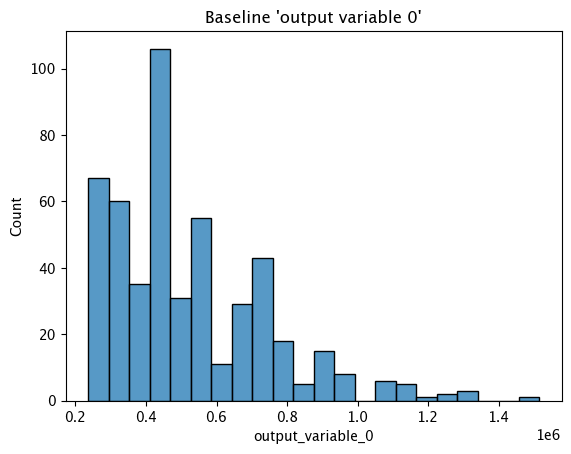

In [ ]:
# get the assay builder histogram from dates
assay_builder_from_dates.baseline_histogram()

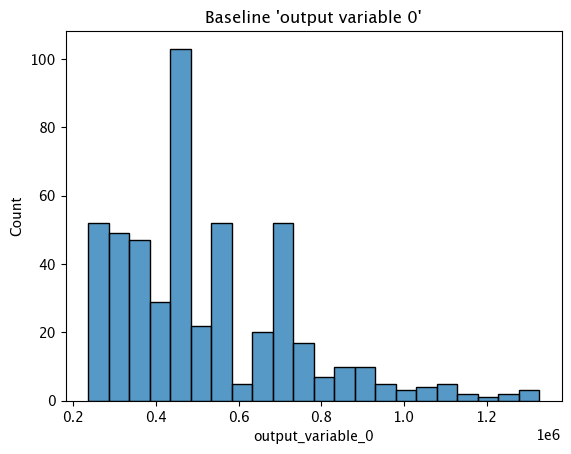

In [ ]:
# get the assay builder histogram from numpy
assay_builder_from_numpy.baseline_histogram()

#### Get Baseline DataFrame

The method [`wallaroo.assay_config.AssayBuilder.baseline_ecdf`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a dataframe of the assay baseline generated from the provided parameters.  This includes:

* metadata:  The inference metadata with the model information, inference time, and other related factors.
* `in` data:  Each input field assigned with the label `in.{input field name}`.
* `out` data:  Each output field assigned with the label `out.{output field name}`

Note that for assays generated from numpy values, there is only the output variable based on the supplied baseline data.

In [33]:
# get the assay dataframe
assay_builder_from_dates.baseline_dataframe().loc[:, ['time', 'output_variable_0']]

,time,output_variable_0
0,1706888751008,1.514079e+06
1,1706888781503,4.045510e+05
2,1706888781503,4.444080e+05
3,1706888781503,2.670140e+05
4,1706888781503,2.918726e+05
...,...,...
496,1706888781503,4.496999e+05
497,1706888781503,5.443921e+05
498,1706888781503,9.173462e+05
499,1706888781503,7.958411e+05


In [34]:
# get the assay dataframe
assay_builder_from_numpy.baseline_dataframe()

,output_variable_0
0,404551.03
1,444408.00
2,267013.97
3,291872.56
4,634262.60
...,...
495,449699.88
496,544392.06
497,917346.20
498,795841.06


### Preview Assay Analyses

By default the assay builder creates an assay that runs a new analysis for every 24 hours (the interval) of the previous 24 hours (the width), starting at the end of the baseline period.  We can perform an **interactive run** to collect the data currently available and evaluate the details.

This requires the following methods:

* **Add Start DateTime**:  The start date for collecting inference records from our Wallaroo pipeline.  In our case, because we just created this pipeline and started inferences, we'll use `assay_window_start` as our starting period.
* **Add Window Run Until**:  This end date for collecting inferences records from our Wallaroo pipeline.  For these examples, we'll use `datetime.datetime.now()` to collect the records up until now.
* **Add Window Interval**:  The interval is the period of time to collect data for.  By default, this every 24 hours starting with the creating of the assay.  For our examples, we'll use every minute.
* **Add Window Width**:  The amount of data to collect.  By default, this is 24 hours.  For example, an interval of 24 hours with a width of 24 hours collects the previous 24 hours of data every 24 hours.  An interval of 12 hours and a width of 24 hours collects the previous 24 hours of data every 12 hours.  For our examples, we'll use every minute.

Interactive runs are launched with `wallaroo.assay_config.interactive_run()` and returns a List of `wallaroo.assay.AssayAnalysis`.  Each AssayAnalysis is a **window** - the combination of the **width** and the **interval**.  The window is compared against the baseline and scored to show how much drift there is from the baseline and the window.

For example, if we do an interactive run for January 1 12:00 PM to January 1 to 1:00 PM, we have 60 minutes of data collected.  If the width and interval are set to 1 minute, then we have 60 windows of individual analyses compared against the baseline.  If we set the width and interval to 5 minutes each, then in the 60 minutes of data we have 12 windows.

At this point, the assay is not saved to the Wallaroo database.  The interactive run is useful for exploring pipeline inference data and experimenting with thresholds.

For our example we will also be adjusting the **width** and **interval** of the assay window to 1 minute and seeing how many windows we have.  Previously we set `assay_window_start` before we started our two separate inference requests, so we should have 2 windows generated from the run.

In [30]:
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()
len(assay_analysis_from_dates)

2

##### Get Assay Analysis List Chart Scores

Assay chart scores show the assay scores for each assay result interval.  Values that are outside of the alert threshold are colored red, while scores within the alert threshold are green.

Assay chart scores are displayed with the method [`wallaroo.assay.AssayAnalysisList.chart_scores(title: Optional[str] = None)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList.chart_scores), with ability to display an optional title with the chart.

The following example shows retrieving the assay results and displaying the chart scores.  From our example, we have two windows - the first should be green, and the second is red showing that values were outside the alert threshold.

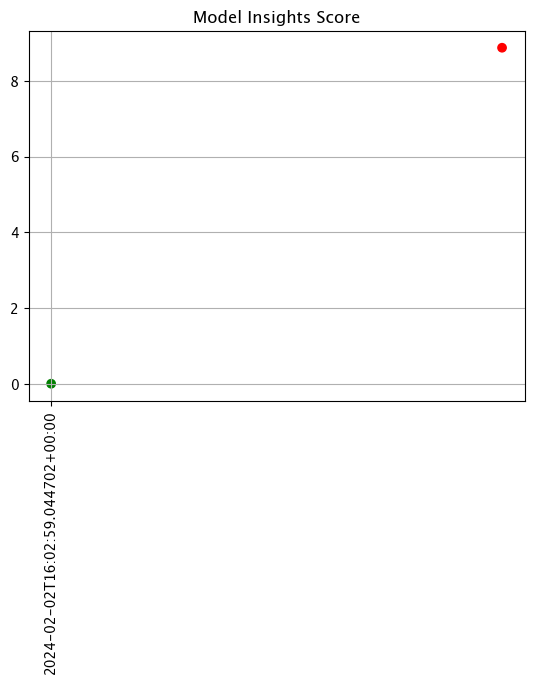

In [36]:
assay_analysis_from_dates.chart_scores()

##### Get Assay Analysis List DataFrame

A DataFrame from `wallaroo.assay.AssayAnalysisList.to_dataframe()` shows the results generated from an Assay Interactive Run for each `AssayAnalysis` element in the `AssayAnalysisList`.  This DataFrame  contains the following fields:

| Field | Type | Description |
|---|---|---|
| assay_id | **Integer/None** | The assay id.  If this is from an interactive run and not an uploaded assay, the id is `None`.
| name | **String/None** | The name of the assay.  If this is from an interactive run and not an uploaded assay, the name is `None`.
| iopath | **String/None** | The iopath of the assay.  If this is from an interactive run and not an uploaded assay, the iopath is `None`.
| score | **Float** | The assay score. |
| start | **DateTime** | The DateTime start of the assay window.
| min | **Float** | The minimum value in the assay window.
| max  | **Float** | The maximum value in the assay window.
| mean | **Float** | The mean value in the assay window.
| median | **Float** | The median value in the assay window.
| std | **Float** | The standard deviation value in the assay window.
| warning_threshold | **Float/None** | The warning threshold of the assay window.
| alert_threshold | **Float/None** | The alert threshold of the assay window.
| status | **String** | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |

For this example, the assay analysis list DataFrame is listed from an interactive run.  For space reasons, only the `score`, `start`, `alert_threshold` and `status` are shown.

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.  The first window should show `status: OK`, with the second window with the very large house prices will show `status: alert`

In [35]:
# get the dataframe from the interactive run
assay_analysis_from_dates.to_dataframe().loc[:, ['score', 'start', 'alert_threshold', 'status']]

,score,start,alert_threshold,status
0,0.010669,2024-02-02T16:02:59.044702+00:00,0.25,Ok
1,8.868491,2024-02-02T16:04:59.044702+00:00,0.25,Alert


##### Get Assay Analysis Chart

The method `wallaroo.assay.AssayAnalysis.chart()` displays a baseline and the assay analysis window statistics chart for a specific analysis with the following fields.

| Field | Type | Description |
|---|---|---|
| **baseline mean** | **Float** | The mean of the baseline values. |
| **window mean** | **Float** | The mean of the window values. |
| **baseline median** | **Float** | The median of the baseline values. |
| **window median** | **Float** | The median of the window values. |
| **bin_mode** | **String** | The binning mode used for the assay. |
| **aggregation** | **String** | The aggregation mode used for the assay. |
| **metric** | **String** | The metric mode used for the assay. |
| **weighted** | **Bool** | Whether the bins were manually weighted. |
| **score** | **Float** | The score from the assay window. |
| **scores** | **List(Float)** | The score from each assay window bin. |
| **index** | **Integer/None** | The window index.  Interactive assay runs are `None`. |

From our example, we have two windows from the interactive run. We will select each one from the assay analysis, and display a chart of their values.

baseline mean = 522403.22891716566
window mean = 522765.305484375
baseline median = 450867.6875
window median = 449699.875
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.010669270380138872
scores = [0.0, 0.0006330976310030018, 0.0021793661132871157, 0.007760103663869021, 9.590536612636926e-05, 7.976058533625192e-07, 0.0]
index = None


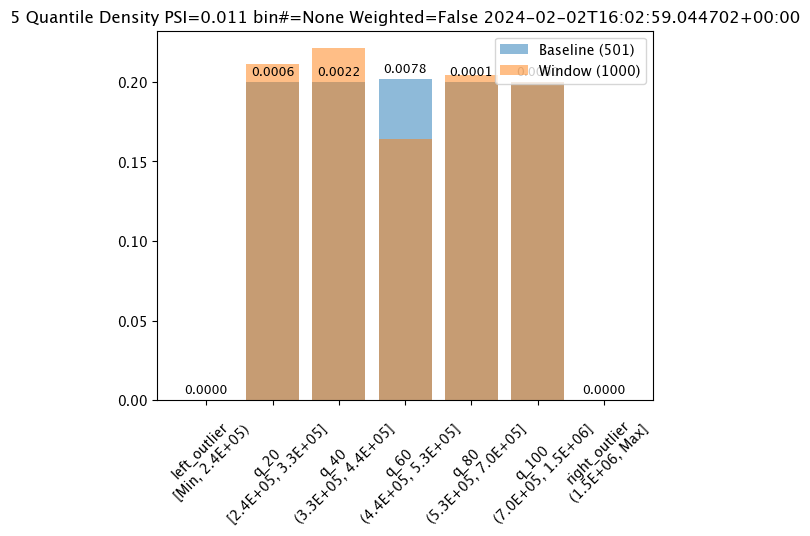

In [39]:
assay_analysis_from_dates[0].chart()

baseline mean = 522403.22891716566
window mean = 1887361.132875
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.868491398148507
scores = [0.0, 0.7174700740703411, 0.7174700740703411, 0.7267853221518462, 0.7174700740703411, 0.7174700740703411, 5.2718257797152965]
index = None


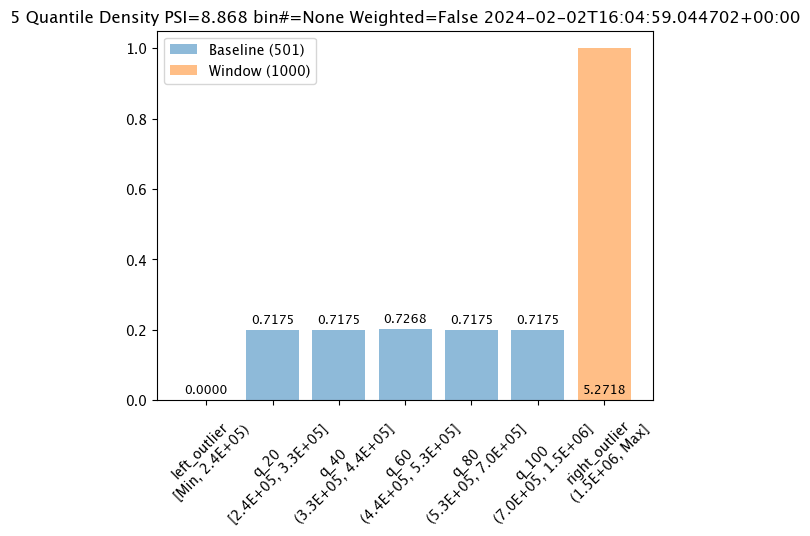

In [40]:
assay_analysis_from_dates[1].chart()

##### Get Assay Analysis Compare Basic Stats

The method `wallaroo.assay.AssayAnalysis.compare_basic_stats` returns a DataFrame with basic stats for the baseline and window data.

In [47]:
assay_analysis_from_dates[0].compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,501.0,1000.0,499.000000,99.600798
min,236238.671875,236238.671875,0.000000,0.000000
max,1514079.375,1489624.25,-24455.125000,-1.615181
mean,522403.228917,522765.305484,362.076567,0.069310
median,450867.6875,449699.875,-1167.812500,-0.259014
std,219978.638799,230942.329556,10963.690757,4.983980
start,None,2024-02-02T16:02:59.044702+00:00,NaN,NaN
end,None,2024-02-02T16:03:59.044702+00:00,NaN,NaN


In [48]:
assay_analysis_from_dates[1].compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,501.0,1000.0,4.990000e+02,99.600798
min,236238.671875,1514079.375,1.277841e+06,540.910890
max,1514079.375,2016006.125,5.019268e+05,33.150623
mean,522403.228917,1887361.132875,1.364958e+06,261.284354
median,450867.6875,1946437.75,1.495570e+06,331.709303
std,219978.638799,155213.047761,-6.476559e+04,-29.441764
start,None,2024-02-02T16:04:59.044702+00:00,NaN,NaN
end,None,2024-02-02T16:05:59.044702+00:00,NaN,NaN


#### Additional Assay Configuration

Assays scoring methods, binning modes, and other settings are adjustable **before the assay is uploaded**.  Below are the most common configurations used for assays.

After making each change, execute another interactive assay run to view how the assay analyses perform.

##### Add Alert Threshold

Assay alert thresholds are modified with the [`wallaroo.assay_config.AssayBuilder.add_alert_threshold(alert_threshold: float)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/) method.  By default alert thresholds are `0.1`.

The following example updates the alert threshold to `0.5`:

In [ ]:
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.add_alert_threshold(0.5)
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

# get the dataframe from the interactive run
assay_analysis_from_dates.to_dataframe().loc[:, ['score', 'start', 'alert_threshold', 'status']]

##### Add Window Interval and Window Width

The interval sets how often to run the assay window from the [`wallaroo.assay_config.AssayBuilder.window_builder.add_interval`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_interval) method to collect data expressed in time units:  "hours=24", "minutes=1", etc.

We can adjust the interval and see how the assays change based on how frequently they are run.

The width sets the time period from the [`wallaroo.assay_config.AssayBuilder.window_builder.add_width`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_width) method to collect data expressed in time units:  "hours=24", "minutes=1", etc.

For this example, we'll adjust the width and interval from 1 minute to 5 minutes and see how the number of analyses and their score changes.

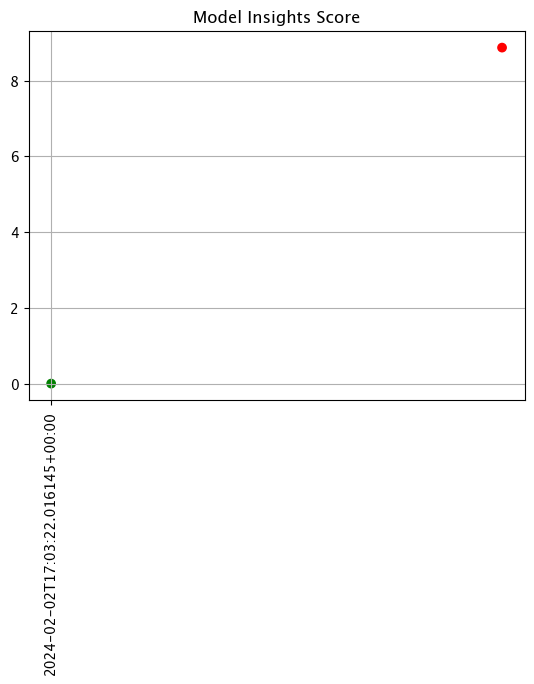

In [80]:
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

# get the chart from the interactive run
assay_analysis_from_dates.chart_scores()

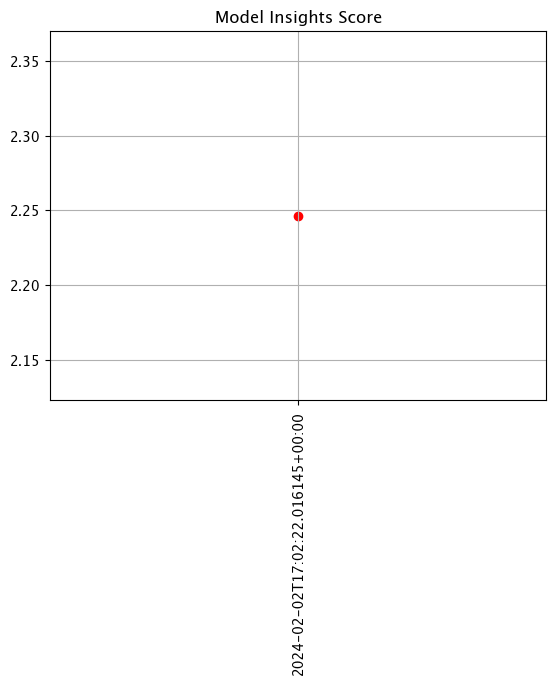

In [81]:
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=5).add_interval(minutes=5).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

# get the chart from the interactive run
assay_analysis_from_dates.chart_scores()

##### Set Number of Bins

The number of bins are set with the `wallaroo.assay_config.UnivariateContinousSummarizerBuilder.add_num_bins(num_bins: int)` method.

The following example sets the number of bins to 10 and displays the updated results of an assay result.

,b_edges,b_edge_names,b_aggregated_values,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,2.362387e+05,left_outlier,0.000000,2.362387e+05,left_outlier,0.0,0.000000
1,2.843365e+05,q_10,0.099800,2.843365e+05,e_2.84e5,0.0,-0.099800
2,3.321350e+05,q_20,0.099800,3.321350e+05,e_3.32e5,0.0,-0.099800
3,3.855618e+05,q_30,0.099800,3.855618e+05,e_3.86e5,0.0,-0.099800
4,4.379298e+05,q_40,0.099800,4.379298e+05,e_4.38e5,0.0,-0.099800
5,4.508677e+05,q_50,0.119760,4.508677e+05,e_4.51e5,0.0,-0.119760
6,5.302889e+05,q_60,0.081836,5.302889e+05,e_5.30e5,0.0,-0.081836
7,5.757247e+05,q_70,0.099800,5.757247e+05,e_5.76e5,0.0,-0.099800
8,7.019407e+05,q_80,0.099800,7.019407e+05,e_7.02e5,0.0,-0.099800
9,7.958411e+05,q_90,0.107784,7.958411e+05,e_7.96e5,0.0,-0.107784


baseline mean = 522403.22891716566
window mean = 1884835.210375
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.122219913417727
scores = [0.0, 0.2838072039839983, 0.2838072039839983, 0.2838072039839983, 0.2838072039839983, 0.3644856882490314, 0.2147793051333076, 0.2838072039839983, 0.2838072039839983, 0.31561967084401865, 0.2526662455720835, 5.2718257797152965]
index = None


/opt/homebrew/anaconda3/envs/wallaroosdk.2023.4.1/lib/python3.8/site-packages/wallaroo/assay.py:317: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=edge_names, rotation=45)


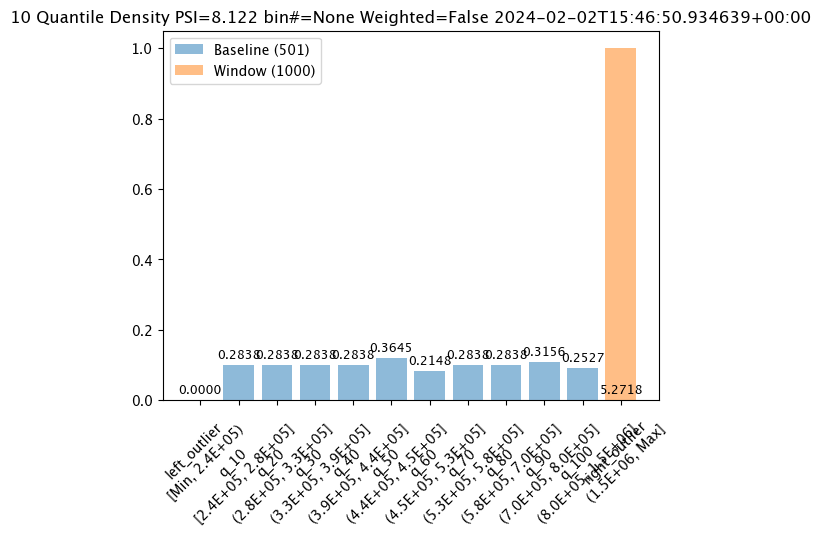

In [49]:
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# update number of bins here
assay_builder_from_dates.summarizer_builder.add_num_bins(10)


assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()


assay_results_df = assay_analysis_from_dates[1].compare_bins()
display(assay_results_df.loc[:, ~assay_results_df.columns.isin(['b_aggregation', 'w_aggregation'])])
assay_analysis_from_dates[1].chart()

##### Binning Modes

Binning modes are modified through the `wallaroo.assay_config.UnivariateContinousSummarizerBuilder.add_bin_mode(bin_mode: bin_mode: wallaroo.assay_config.BinMode, edges: Optional[List[float]] = None)`.

`bin_mode` values are the following from `wallaroo.assay_config.Binmode`:

* `QUANTILE` (*Default*): Based on percentages. If `num_bins` is 5 then quintiles so bins are created at the 20%, 40%, 60%, 80% and 100% points.
* `EQUAL`: Evenly spaced bins where each bin is set with the formula `min - max / num_bins`
* `PROVIDED`: The user provides the edge points for the bins.

If `PROVIDED` is supplied, then a List of float values must be provided for the `edges` parameter that matches the number of bins.

The previous assay examples used quintiles so all of the bins had the same percentage/count of samples.  

The following example uses `BinMode.EQUAL`, then displays the baseline bins created and charts resulting from that binning mode.

,b_edges,b_edge_names,b_aggregated_values,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,2.362387e+05,left_outlier,0.000000,2.362387e+05,left_outlier,0.000000,0.0
1,4.918068e+05,p_4.92e5,0.558882,4.918068e+05,e_4.92e5,0.558882,0.0
2,7.473750e+05,p_7.47e5,0.303393,7.473750e+05,e_7.47e5,0.303393,0.0
3,1.002943e+06,p_1.00e6,0.101796,1.002943e+06,e_1.00e6,0.101796,0.0
4,1.258511e+06,p_1.26e6,0.027944,1.258511e+06,e_1.26e6,0.027944,0.0
5,1.514079e+06,p_1.51e6,0.007984,1.514079e+06,e_1.51e6,0.007984,0.0
6,NaN,right_outlier,0.000000,NaN,right_outlier,0.000000,0.0


baseline mean = 522403.22891716566
window mean = 1884835.210375
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Equal
aggregation = Density
metric = PSI
weighted = False
score = 9.441870146831576
scores = [0.0, 2.612386044992322, 1.2250807267351915, 0.2916995446658736, 0.03948150698687936, 0.0013965437360113336, 5.2718257797152965]
index = None


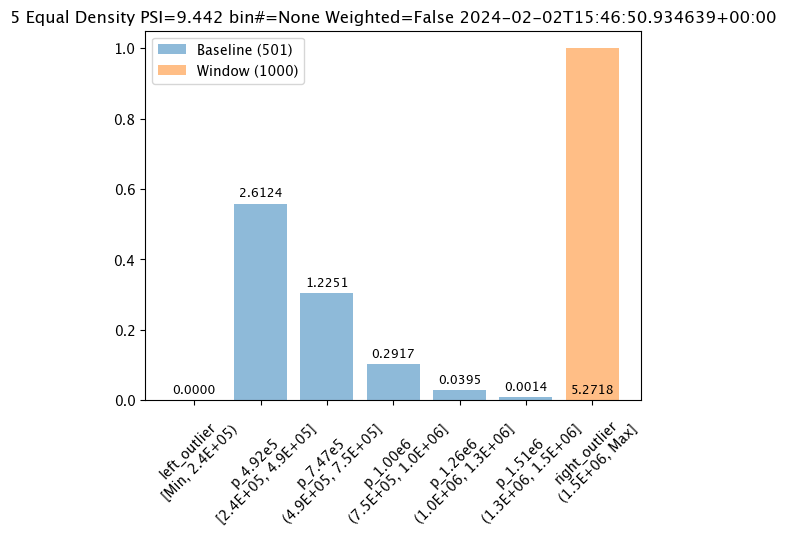

In [52]:
#from wallaroo.assay_config import BinMode

assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# update binning mode here
assay_builder_from_dates.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.EQUAL)


assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()


assay_results_df = assay_analysis_from_dates[0].compare_bins()
display(assay_results_df.loc[:, ~assay_results_df.columns.isin(['b_aggregation', 'w_aggregation'])])
assay_analysis_from_dates[1].chart()

The following example manually sets the bin values.

The values in this dataset run from 200000 to 1500000. We can specify the bins with the `BinMode.PROVIDED` and specifying a list of floats with the right hand / upper edge of each bin and optionally the lower edge of the smallest bin. If the lowest edge is not specified the threshold for left outliers is taken from the smallest value in the baseline dataset.

,b_edges,b_edge_names,b_aggregated_values,w_edges,w_edge_names,w_aggregated_values,diff_in_pcts
0,200000.0,left_outlier,0.000000,200000.0,left_outlier,0.000,0.000000
1,400000.0,e_4.00e5,0.301397,400000.0,e_4.00e5,0.000,-0.301397
2,600000.0,e_6.00e5,0.407186,600000.0,e_6.00e5,0.000,-0.407186
3,800000.0,e_8.00e5,0.199601,800000.0,e_8.00e5,0.000,-0.199601
4,1500000.0,e_1.50e6,0.089820,1500000.0,e_1.50e6,0.000,-0.089820
5,2000000.0,e_2.00e6,0.001996,2000000.0,e_2.00e6,0.676,0.674004
6,NaN,right_outlier,0.000000,NaN,right_outlier,0.324,0.324000


baseline mean = 522403.22891716566
window mean = 1887361.132875
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Provided
aggregation = Density
metric = PSI
weighted = False
score = 9.203690712052236
scores = [0.0, 1.2149295084486744, 1.7695489013855132, 0.7174700740703411, 0.2449928996579785, 3.926102841018453, 1.330646487471275]
index = None


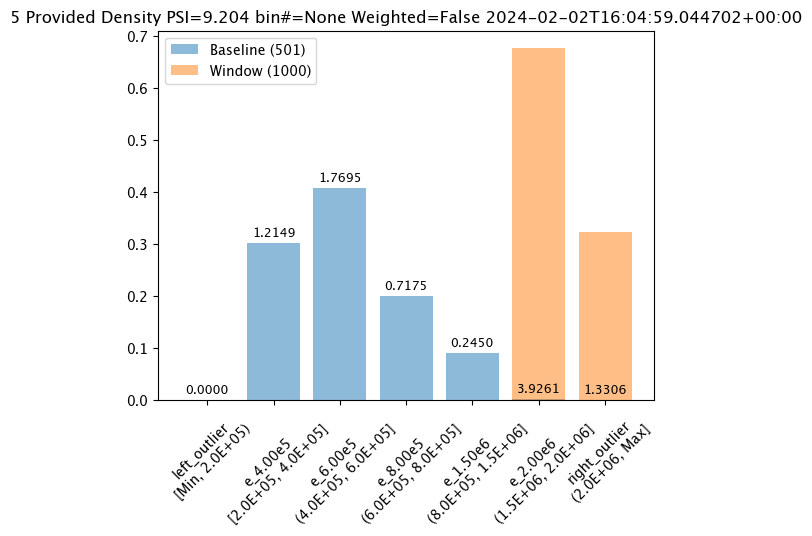

In [56]:
#from wallaroo.assay_config import BinMode

assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

edges = [200000.0, 400000.0, 600000.0, 800000.0, 1500000.0, 2000000.0]

# update binning mode here
assay_builder_from_dates.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.PROVIDED, edges)


assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()


assay_results_df = assay_analysis_from_dates[1].compare_bins()
display(assay_results_df.loc[:, ~assay_results_df.columns.isin(['b_aggregation', 'w_aggregation'])])
assay_analysis_from_dates[1].chart()

##### Add Metric

The `score` is a distance or dis-similarity measure. The larger it is the less similar the two distributions are.  The following methods are provided determining the score:

* `PSI` (*Default*) - Population Stability Index (PSI).
* `MAXDIFF`: Maximum difference between corresponding bins.
* `SUMDIFF`: Mum of differences between corresponding bins.

The metric type used is updated with the [`wallaroo.assay_config.AssayBuilder.add_metric(metric: wallaroo.assay_config.Metric)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_metric) method.

The following three charts use each of the metrics.  Note how the scores change based on the score type used.

baseline mean = 522403.22891716566
window mean = 1887361.132875
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.868491398148507
scores = [0.0, 0.7174700740703411, 0.7174700740703411, 0.7267853221518462, 0.7174700740703411, 0.7174700740703411, 5.2718257797152965]
index = None


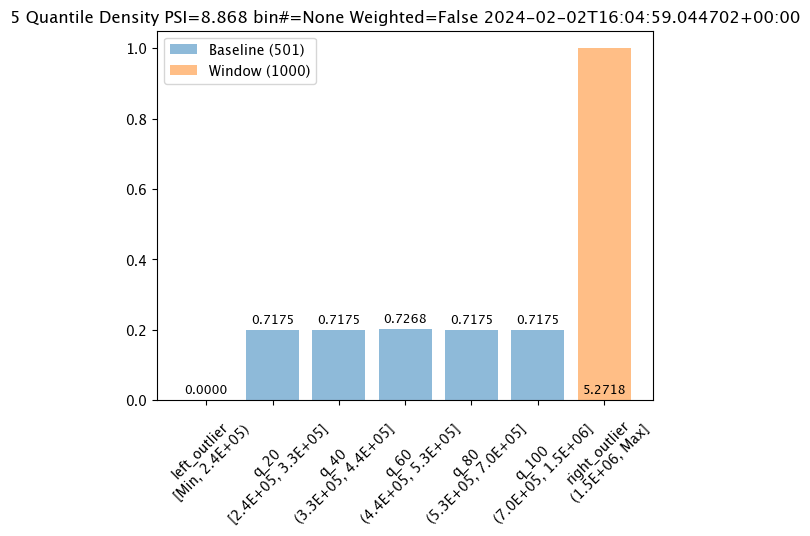

In [57]:
#PSI Score - the default

assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.PSI)
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

assay_analysis_from_dates[1].chart()

baseline mean = 522403.22891716566
window mean = 1887361.132875
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = SumDiff
weighted = False
score = 1.0
scores = [0.0, 0.1996007984031936, 0.1996007984031936, 0.20159680638722555, 0.1996007984031936, 0.1996007984031936, 1.0]
index = None


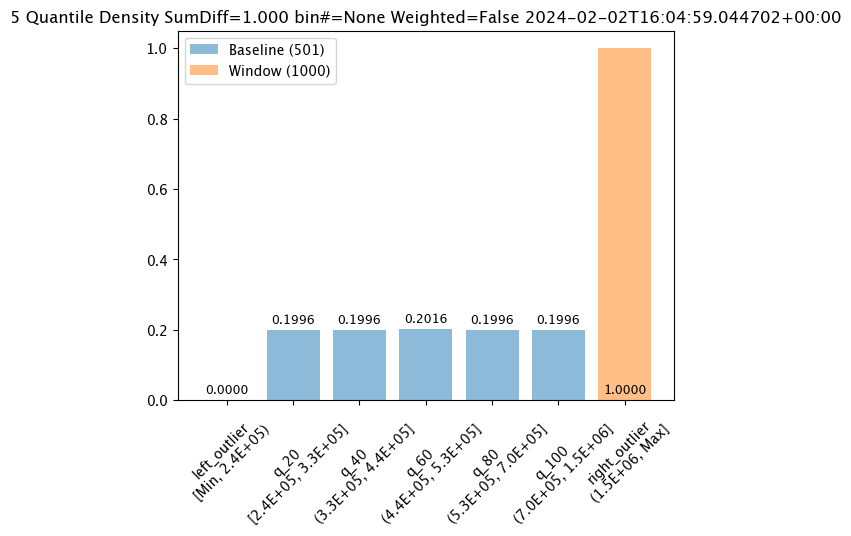

In [58]:
#SUMDIFF Score

assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.SUMDIFF)
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

assay_analysis_from_dates[1].chart()

baseline mean = 522403.22891716566
window mean = 1887361.132875
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = MaxDiff
weighted = False
score = 1.0
scores = [0.0, 0.1996007984031936, 0.1996007984031936, 0.20159680638722555, 0.1996007984031936, 0.1996007984031936, 1.0]
index = 6


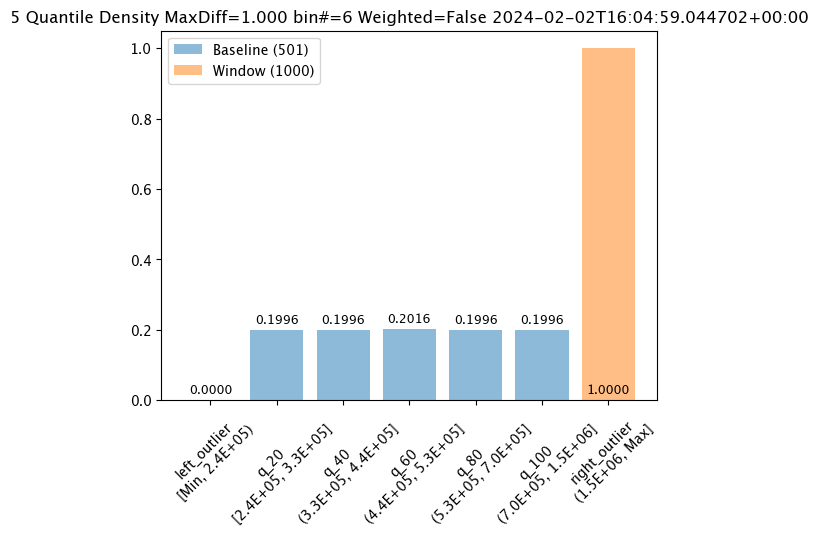

In [59]:
#MAXDIFF Score

assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.MAXDIFF)
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

assay_analysis_from_dates[1].chart()

##### Aggregation Options

Assay aggregation options are modified with the [`wallaroo.assay_config.AssayBuilder.add_aggregation(aggregation: wallaroo.assay_config.Aggregation)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_aggregation) method.  The following options are provided:

* `Aggregation.DENSITY` (*Default*): Count the number/percentage of values that fall in each bin. 
* `Aggregation.CUMULATIVE`: Empirical Cumulative Density Function style, which keeps a cumulative count of the values/percentages that fall in each bin.

The following example demonstrate the different results between the two.

baseline mean = 522403.22891716566
window mean = 1887361.132875
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.868491398148507
scores = [0.0, 0.7174700740703411, 0.7174700740703411, 0.7267853221518462, 0.7174700740703411, 0.7174700740703411, 5.2718257797152965]
index = None


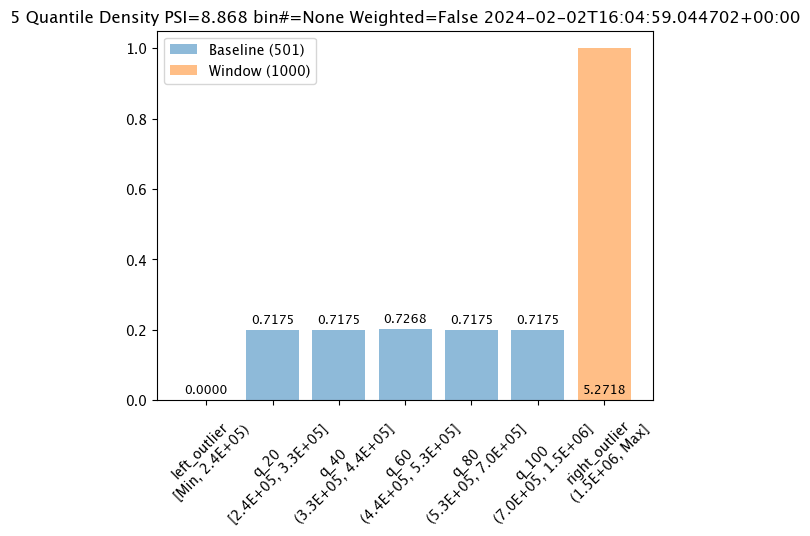

In [60]:
#Aggregation.DENSITY - the default

assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.DENSITY)
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

assay_analysis_from_dates[1].chart()

baseline mean = 522403.22891716566
window mean = 1887361.132875
baseline median = 450867.6875
window median = 1946437.75
bin_mode = Quantile
aggregation = Cumulative
metric = PSI
weighted = False
score = 3.0
scores = [0.0, 0.1996007984031936, 0.3992015968063872, 0.6007984031936128, 0.8003992015968064, 1.0, 0.0]
index = None


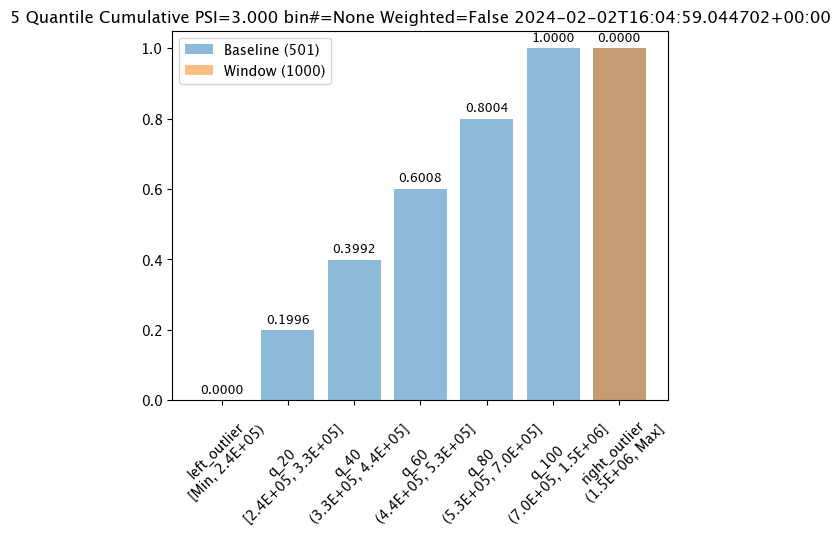

In [63]:
#Aggregation.CUMULATIVE

assay_builder_from_dates = wl.build_assay(assay_name="assays from date sample", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.CUMULATIVE)
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_analysis_from_dates = assay_config_from_dates.interactive_run()

assay_analysis_from_dates[1].chart()

### Upload Assay

With the assay created and fully tested, we will upload it to the Wallaroo instance.  This will make it available for future demonstrations and visible through the Wallaroo UI.

In [68]:
assay_builder_from_dates = wl.build_assay(assay_name="assays from dates sample", 
                                          pipeline=mainpipeline, 
                                          model_name="housepricesagacontrol", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width and interval for the assay

assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.upload()

6

The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.

![Sample assay in the UI](images/housepricesaga-sample-assay.png)

### List Assays

A list of the current assays and their status is retrieved with the `wallaroo.client.list_assays()` method.

In [72]:
wl.list_assays()

name,active,status,warning_threshold,alert_threshold,pipeline_name
assays from date sample,True,"{""run_at"": ""2024-02-02T17:25:45.937825577+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date baseline,True,"{""run_at"": ""2024-02-02T17:25:45.954378703+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from numpy,True,created,None,0.25,assay-demonstration-tutorial


### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [73]:
mainpipeline.undeploy()

name,assay-demonstration-tutorial
created,2024-02-01 19:46:24.140658+00:00
last_updated,2024-02-02 15:45:47.349676+00:00
deployed,False
arch,None
tags,
versions,"eedae8d6-ab61-42ab-b9e8-5bf5e4511158, fece4440-2841-45f1-bb5f-95fcdc959327, 9c5a5b72-4976-406b-a4a3-f02e730bb9db, b917929a-01d0-4690-9c08-5edd2094761d"
steps,housepricesagacontrol
published,False
